In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.io import loadmat
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

In [2]:
# initialize plotly 
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
# load the data
data = loadmat('Machine Learning Projects/data')

In [4]:
data['addedNoisePercent'][0]

array([0.1])

In [5]:
# create a pandas dataframe of the data
spectra_df = pd.DataFrame(data=data['spectra'])
labels_df = pd.DataFrame(data=data['labels'],columns=['analyte'])
substrate_df = pd.DataFrame(data=data['substrateIDs'],columns=['substrate'])
df = pd.concat([spectra_df,labels_df,substrate_df],axis=1)

In [6]:
# define a function that plots a single instance
def plot_instance(instance):
    df.iloc[instance].drop(['analyte','substrate']).iplot(theme='white',
                                                          color='#c51b8a',
                                                          xTitle = 'Feature',
                                    title=f"Analyte {data['labels'][instance]} on Substrate {data['substrateIDs'][instance]}")

In [7]:
# define a function that plots a specified number of instances that on top of a certain substrate
# mainly to visualize the noise caused by the substrate and observe similarities
def plot_instances_on_substrate(substrate,start_idx=0,n_instances=5):
    df[df['substrate']==substrate].drop(['analyte','substrate'],axis=1).reset_index(drop=True)[start_idx:start_idx+n_instances].T.iplot(theme='white',
                                                                                                                      colorscale='rdpu',
                                                                                                                     title = f"Analytes {start_idx} to {start_idx+n_instances-1} on Substrate {substrate}")

In [8]:
# analyte 1 (dibenzoyl peroxide) on substrate 1 (soda-lime glass), 0.1% noise
plot_instance(0)

In [9]:
# analyte 14 (heroin) on substrate 1 (soda-lime glass), no noise
plot_instance(1301)

In [10]:
plot_instances_on_substrate(substrate=2,start_idx=2,n_instances=5)

In [11]:
import tensorflow as tf

In [12]:
# create labels column which will be used in the model
df['labels'] = np.array(df['analyte'])-1

In [13]:
# create the X_train, X_valid, and X_test sets
X_train_full, X_test = np.array(df.drop(['analyte','substrate','labels'],axis=1)[:37125]), np.array(df.drop(['analyte','substrate','labels'],axis=1)[37125:])
X_valid, X_train = X_train_full[:9281], X_train_full[9281:]

In [14]:
# create the y_train, y_valid, and y_test sets
y_train_full, y_test = np.array(df['labels'].iloc[:37125]), np.array(df['labels'].iloc[37125:])
y_valid, y_train = y_train_full[:9281], y_train_full[9281:]

In [15]:
# import the MinMax scaler from the sklearn library to scale the data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [16]:
scaler.fit_transform(X_train)

array([[0.81297409, 0.80885768, 0.81217563, ..., 0.8958643 , 0.89534512,
        0.89730421],
       [0.81405792, 0.81823715, 0.83281451, ..., 0.89986344, 0.89960397,
        0.89894335],
       [0.80998101, 0.81540429, 0.82874518, ..., 0.90398957, 0.90341023,
        0.90082248],
       ...,
       [0.14521217, 0.14925873, 0.14849198, ..., 0.87646634, 0.87555977,
        0.86730678],
       [0.14791951, 0.14305088, 0.1399571 , ..., 0.87092913, 0.86893074,
        0.87342336],
       [0.14602918, 0.14587762, 0.14338015, ..., 0.87493884, 0.87563247,
        0.87445844]])

In [17]:
scaler.transform(X_valid)

array([[0.04533309, 0.04609835, 0.04627755, ..., 0.028713  , 0.02646255,
        0.03494595],
       [0.04757819, 0.04161474, 0.05305592, ..., 0.02717661, 0.03545342,
        0.03159431],
       [0.04470308, 0.04675994, 0.04712862, ..., 0.02942522, 0.02866438,
        0.03792454],
       ...,
       [0.78755172, 0.8077238 , 0.77369422, ..., 0.85326   , 0.84539791,
        0.82724666],
       [0.78747351, 0.78519241, 0.79239254, ..., 0.84091932, 0.84165599,
        0.84219463],
       [0.81475321, 0.81855683, 0.83461725, ..., 0.90364782, 0.90289417,
        0.90247727]])

In [18]:
scaler.transform(X_test)

array([[0.1448979 , 0.16637257, 0.12980667, ..., 0.89355145, 0.88465218,
        0.8638568 ],
       [0.14906154, 0.13670049, 0.12955214, ..., 0.87115858, 0.87177707,
        0.87353968],
       [0.14550139, 0.14259422, 0.14063229, ..., 0.87500025, 0.87446079,
        0.87447876],
       ...,
       [0.04650376, 0.0573455 , 0.07756817, ..., 0.75463087, 0.76015971,
        0.77228764],
       [0.06336767, 0.06394713, 0.06822308, ..., 0.77276533, 0.76866266,
        0.77438648],
       [0.06493815, 0.06707189, 0.06745685, ..., 0.77557943, 0.77489539,
        0.77593611]])

In [19]:
# standardize the data by subtracting the mean and dividing by the standard deviation
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# add a new axis so that the shape of the input data matches the model's specifications
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
# it is not advised to run any of the cells below, as it will reset the model. This will result in having to retrain the model, 
# which will take hours and may not yield the same results, as the random seed initialization plays a part in getting the model
# to start learning. 

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# create a checkpoint callback that saves the best model after each training epoch 
# by comparing the model's validation loss to that of the previous epoch
checkpoint = ModelCheckpoint('spectral_multiclass_CNN_best_model.h5', monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

In [20]:
# create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, LeakyReLU

from functools import partial

# create a wrapper around the Conv1D class, mainly to save space
DefaultConv1D = partial(tf.keras.layers.Conv1D,
                        kernel_size=3, padding="SAME")
model = Sequential()

# 3 convolution layers, with an increasing number of filters to capture increasingly complex patterns
# BatchNormalization after each convolutional layer, to ensure stability and optimal training time for the model
# Pooling layers with pool_size = 2 the reduce dimensionality of the output tensor from the convolutional layer
model.add(DefaultConv1D(filters=64, kernel_size=7, input_shape=[1701,1]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(DefaultConv1D(filters=128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(DefaultConv1D(filters=256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# after feature extraction is complete, flatten the data and feed it into an MLP (multi-layer perceptron)
model.add(Flatten())

# 2 dense layers, with the LeakyReLU activation function to prevent the vanishing gradient problem
model.add(Dense(units=300,kernel_initializer="he_normal"))
model.add(LeakyReLU())
model.add(Dropout(0.2))

# he_normal kernel initializer to initialize the weights in a normal distribution, which may speed up training
model.add(Dense(units=150,kernel_initializer="he_normal"))
model.add(LeakyReLU())
model.add(Dropout(0.2))

# softmax function outputs a list of probablities, which are like confidence scores
# 55 neurons to match the 55 analytes
model.add(Dense(55, activation='softmax'))

# SGD optimizer with a 10% decay, to make the model converge to an optimum faster (taking smaller and smaller steps)
# the momentum parameter makes the SGD optimizer take into account the previous gradients, which also improves learning speed
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3,decay=1e-4,momentum=0.9),
              metrics=["accuracy"])

In [42]:
# fit the model to the training data, using the validation set to test the model after every epoch
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint])

In [34]:
# load the best model
best_model = tf.keras.models.load_model('spectral_multiclass_CNN_best_model.h5')

# get predictions on the test set, which is a list of lists of probabilites
y_pred = best_model.predict(X_test)

# use a loop to get the analyte with the highest probability in each list, and append those to the predictions list
predictions = []
for i in range (len(y_pred)):
    predictions.append(
        np.argmax(y_pred[i])
    )

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[83  0  0 ...  0  0  0]
 [ 0 72  0 ...  0  0  0]
 [ 0  9 77 ...  0  0  0]
 ...
 [ 0  3  0 ... 97  0  0]
 [ 0  4  0 ...  0 60  0]
 [ 0  7  0 ...  0  0 75]]


              precision    recall  f1-score   support

           0       1.00      0.89      0.94        93
           1       0.20      0.70      0.32       103
           2       0.88      0.82      0.85        94
           3       0.89      0.34      0.49        91
           4       0.57      0.82      0.67       109
           5       0.23      0.57      0.33       116
           6       0.99      0.90      0.94        92
           7       1.00      0.80      0.89        91
           8       1.00      0.89      0.94        99
           9       0.67      0.73      0.70       120
          10       1.00      0.97      0.99       107
          11       0.94      0.95      0.94        92
          12       1.00      0.88      0.94        84
          13       1.00      0.85      0.92        97
          14       1.00      0.

<AxesSubplot:>

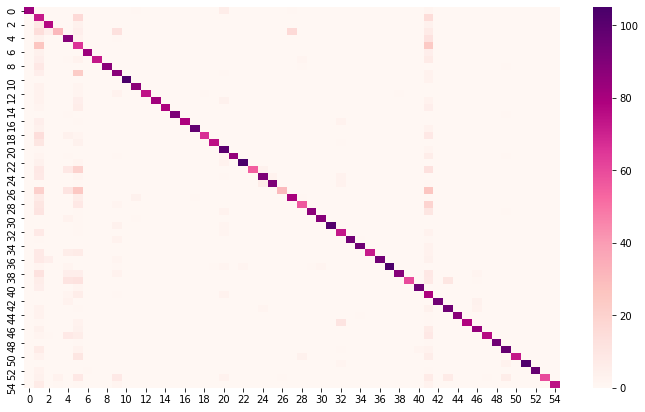

In [38]:
# create heatmap of the confusion matrix
plt.figure(figsize=(12,7))
sns.heatmap(confusion_matrix(y_test,predictions),cmap='RdPu')